In [1]:
import polars as pl
import polars.selectors as cs
import seaborn as sbn
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)
print(pl.__version__)

1.6.0


Okay! We're going back to our bike path dataset here. I live in Montreal, and I was curious about whether we're more of a commuter city or a biking-for-fun city -- do people bike more on weekends, or on weekdays?

# 4.1 Adding a 'weekday' column to our dataframe

First, we need to load up the data. We've done this before.

<Axes: xlabel='Date', ylabel='Berri 1'>

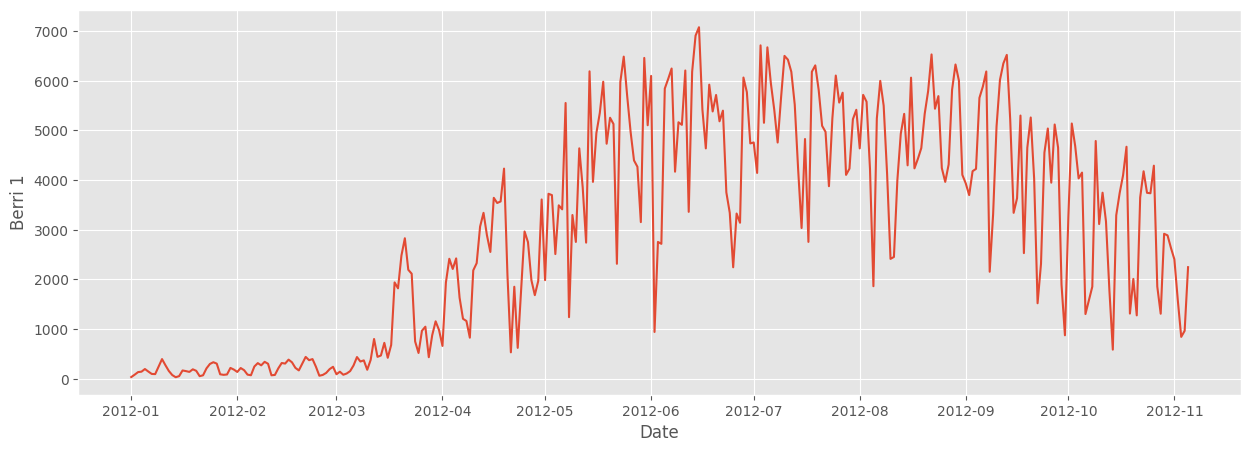

In [2]:
bikes = pl.read_csv('../data/bikes.csv', separator=';', encoding='latin1', try_parse_dates=True)
bikes.plot.line(x='Date', y='Berri 1').properties(width='container')
sbn.lineplot(bikes, x='Date', y='Berri 1')

Next up, we're just going to look at the Berri bike path. Berri is a street in Montreal, with a pretty important bike path. I use it mostly on my way to the library now, but I used to take it to work sometimes when I worked in Old Montreal. 

So we're going to create a dataframe with just the Berri bikepath in it

In [3]:
berri_bikes = bikes.select('Date', 'Berri 1')

In [4]:
berri_bikes.head()

Date,Berri 1
date,i64
2012-01-01,35
2012-01-02,83
2012-01-03,135
2012-01-04,144
2012-01-05,197


Next, we need to add a 'weekday' column. Firstly, we can get the weekday from the `Date` column. It's basically all the days of the year.

In [5]:
berri_bikes['Date']

Date
date
2012-01-01
2012-01-02
2012-01-03
2012-01-04
2012-01-05
…
2012-11-01
2012-11-02
2012-11-03


You can see that actually some of the days are missing -- only 310 days of the year are actually there. Who knows why.

Polars has a bunch of really great time series functionality, so if we wanted to get the day of the month for each row, we could do it like this:

In [6]:
berri_bikes['Date'].dt.ordinal_day()

Date
i16
1
2
3
4
5
…
306
307
308


We actually want the weekday, though:

In [7]:
berri_bikes['Date'].dt.weekday()

Date
i8
7
1
2
3
4
…
4
5
6


These are the days of the week, where 1 is Monday. I found out that 1 was Monday from the [documentation](https://pola-rs.github.io/polars/py-polars/html/reference/expressions/api/polars.Expr.dt.weekday.html#polars.Expr.dt.weekday).

Now that we know how to *get* the weekday, we can add it as a column in our dataframe using the `df.with_columns` function. This function behaves a lot like `df.select` except that it also preserves the original columns of the DataFrame (overwriting any re-defined columns).

In [8]:
berri_bikes = berri_bikes.with_columns(
    weekday = pl.col('Date').dt.weekday()
)
berri_bikes.head()

Date,Berri 1,weekday
date,i64,i8
2012-01-01,35,7
2012-01-02,83,1
2012-01-03,135,2
2012-01-04,144,3
2012-01-05,197,4


# 4.2 Adding up the cyclists by weekday

This turns out to be really easy!

Dataframes have a `.group_by()` method that is similar to SQL groupby, if you're familiar with that. I'm not going to explain more about it right now -- if you want to to know more, [the documentation](https://pola-rs.github.io/polars/py-polars/html/reference/dataframe/api/polars.DataFrame.groupby.html) is really good.

In this case, `berri_bikes.group_by('weekday').agg(sum)` means "Group the rows by weekday and then add up all the values with the same weekday".

In [9]:
weekday_counts = (
    berri_bikes
    .group_by('weekday')
    .agg(pl.col('Berri 1').sum())
    .sort('weekday')
)
weekday_counts

weekday,Berri 1
i8,i64
1,134298
2,135305
3,152972
4,160131
5,141771
6,101578
7,99310


It's hard to remember what 1, 2, 3, 4, 5, 6, 7 mean, so we can fix it up and graph it:

In [10]:
days_df = pl.DataFrame(
    data={
        "weekday" :range(1, 8),
        "weekday_name": ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    },
    schema_overrides={'weekday':pl.Int8} # Make sure the type matches our weekday_counts dataframe
)
weekday_counts = weekday_counts.join(days_df, on='weekday')
weekday_counts

weekday,Berri 1,weekday_name
i8,i64,str
1,134298,"""Monday"""
2,135305,"""Tuesday"""
3,152972,"""Wednesday"""
4,160131,"""Thursday"""
5,141771,"""Friday"""
6,101578,"""Saturday"""
7,99310,"""Sunday"""


<Axes: xlabel='weekday_name', ylabel='Berri 1'>

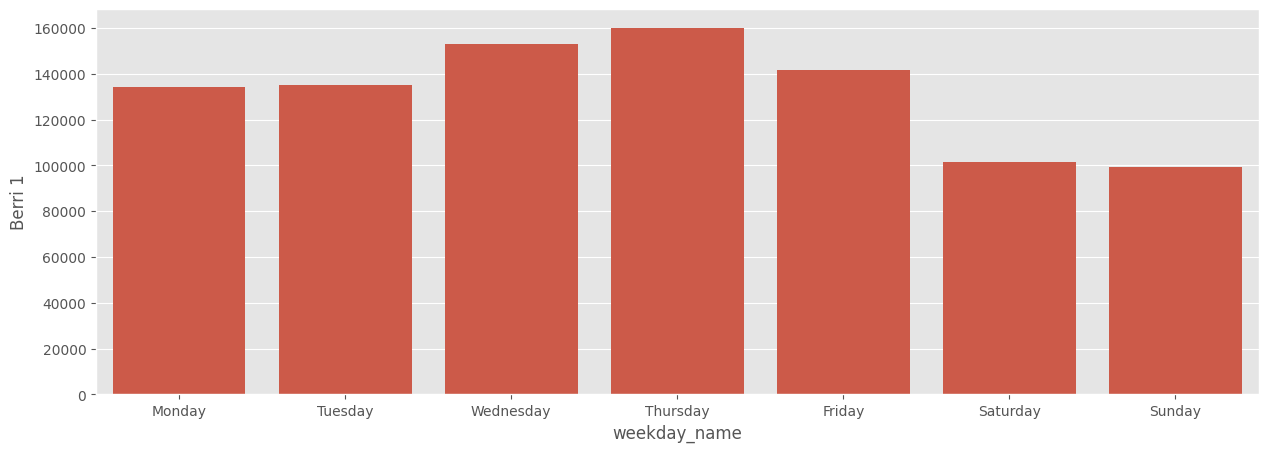

In [11]:
sbn.barplot(weekday_counts, x='weekday_name', y='Berri 1')

So it looks like Montrealers are commuter cyclists -- they bike much more during the week. Neat!

# 4.3 Putting it together

We scan and join the dataframes in lazy mode so data is only computed when requred by the process.

<Axes: xlabel='weekday_name', ylabel='Berri 1'>

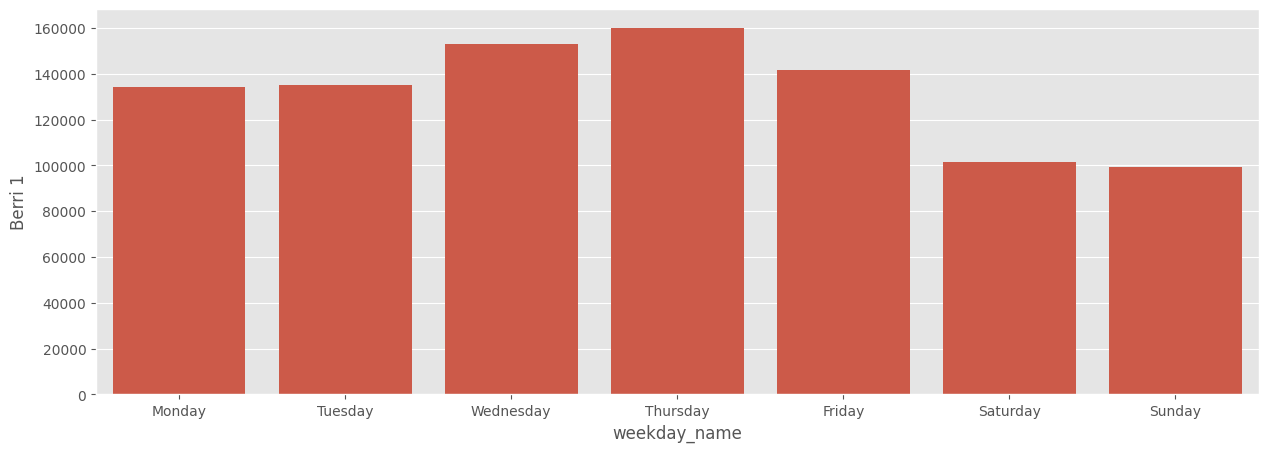

In [12]:
# scan_csv is lazy method that optimizes query only once data is needed to plot.
bikes = pl.scan_csv('../data/bikes.csv', separator=';', encoding='utf8', try_parse_dates=True)

# get weekday data for Berri 1 path
berri_bikes = bikes.select('Berri 1', weekday = pl.col('Date').dt.weekday())

# Add up the number of cyclists by weekday
weekday_counts = (
    berri_bikes.group_by('weekday')
    .agg(pl.col('Berri 1').sum())
    .join(days_df.lazy(), on='weekday')
    .sort('weekday')
)
sbn.barplot(weekday_counts.collect(), x='weekday_name', y='Berri 1')